In [1]:
%matplotlib widget
import os, re
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F

from lightly.data import LightlyDataset
from lightly.data import ImageCollateFunction
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss
import lightly

from avalanche.models import SimpleCNN
from avalanche.benchmarks.datasets import CORe50Dataset

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pandas as pd
from PIL import Image
import cv2

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
from lightly.data import SimCLRCollateFunction
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamProjectionHead
from lightly.models.modules import SimSiamPredictionHead


class SimSiam(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimSiamProjectionHead(512, 512, 128)
        self.prediction_head = SimSiamPredictionHead(128, 64, 128)

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

In [4]:
resnet = lightly.models.ResNetGenerator('resnet-9')
backbone = nn.Sequential(*list(resnet.children())[:-1],nn.AdaptiveAvgPool2d(1))

# backbone = CoilCNNBackbone(in_channels = 3)

# simpleCNN = SimpleCNN()
# backbone = nn.Sequential(*list(simpleCNN.children())[:-1][0][:-2],nn.AdaptiveAvgPool2d(2))


model = SimSiam(backbone)
model = model.to(device)

model.train()

SimSiam(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
    )
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [5]:
transform = transforms.Compose(
                            [transforms.Resize((64, 64))])

core50 = CORe50Dataset(train=True, transform=transform)
dataset = LightlyDataset.from_torch_dataset(core50)
collate_fn = SimCLRCollateFunction(input_size=64)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

Loading labels...
Loading LUP...
Loading labels names...
Files already downloaded and verified


In [4]:
from torchvision.transforms import Compose, ToTensor, Resize
transform = Compose([ToTensor()])

dataset = CORe50Dataset(train=True, transform=transform, object_level=True)
# dataset = LightlyDataset.from_torch_dataset(dataset)

# ss_inds = list(range(0,len(core50.targets),30))
# core50 = torch.utils.data.Subset(core50, ss_inds)


Loading labels...
Loading LUP...
Loading labels names...
Files already downloaded and verified


In [9]:
import cv2

data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=8)

frame_count = 16
f_ind = 0
previous_frame = None
img_iter = iter(data_loader)
while f_ind < frame_count:
    f_ind += 1
    imgs, labels = next(img_iter)
    img = np.array(imgs[0]*255, dtype = np.uint8)
    img_rgb = np.transpose(img, (1, 2, 0))
    prepared_frame = 0

    if ((frame_count % 2) == 0):

        # 2. Prepare image; grayscale and blur
        prepared_frame = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        prepared_frame = cv2.GaussianBlur(src=prepared_frame, ksize=(3,3), sigmaX=0)

        # 2. Calculate the difference
    if (previous_frame is None):
        # First frame; there is no previous one yet
        previous_frame = prepared_frame
        continue

    # calculate difference and update previous frame
    diff_frame = cv2.absdiff(src1=previous_frame, src2=prepared_frame)
    previous_frame = prepared_frame

    # 4. Dilute the image a bit to make differences more seeable; more suitable for contour detection
    kernel = np.ones((17, 17))
    diff_frame = cv2.dilate(diff_frame, kernel, 1)

    # 5. Only take different areas that are different enough (>20 / 255)
    thresh_frame = cv2.threshold(src=diff_frame, thresh=70, maxval=255, type=cv2.THRESH_BINARY)[1]

    # 6. Find and optionally draw contours
    contours, _ = cv2.findContours(image=thresh_frame, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    # Comment below to stop drawing contours
    img_rgb_contoured = img_rgb.copy()
    cv2.drawContours(image=img_rgb_contoured, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    # Uncomment 6 lines below to stop drawing rectangles
    # for contour in contours:
    #   if cv2.contourArea(contour) < 50:
    #     # too small: skip!
    #       continue
    #   (x, y, w, h) = cv2.boundingRect(contour)
    #   cv2.rectangle(img=img_rgb, pt1=(x, y), pt2=(x + w, y + h), color=(0, 255, 0), thickness=2)



    # Cleanup
    # cv2.destroyAllWindows()


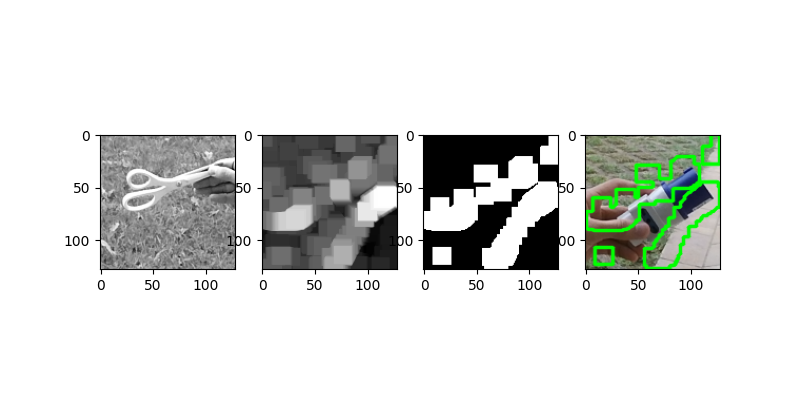

In [59]:
fig,axes = plt.subplots(1,4, figsize=(8,4))
axes[0].imshow(prvs, cmap='gray')
axes[1].imshow(diff_frame, cmap='gray')
axes[2].imshow(thresh_frame, cmap='gray')
axes[3].imshow(img_rgb_contoured)

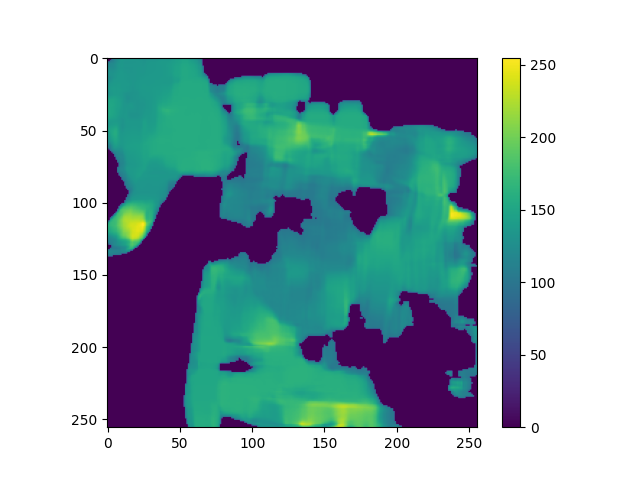

In [21]:
import cv2 as cv
import matplotlib.animation as animation
import os
from os import listdir
 
# get the path/directory
folder_dir = "/home/ehajizad/ss_learning/ssl_tests/datasets/icwt/part1_cropped/book/book2/ROT2D/day6/left/"
images = []
for filename in os.listdir(folder_dir):
    img = cv2.imread(os.path.join(folder_dir,filename))
    if img is not None:
        images.append(img)

        

fn = 50

# cap = cv.VideoCapture(cv.samples.findFile("vtest.avi"))
# ret, frame1 = cap.read()
frame1 = images[0]
prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
f_ind=0

fig = plt.figure()


ims = []
while f_ind < fn:
    f_ind += 1

    frame2 = images[f_ind]
    next_f = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)

    flow = cv.calcOpticalFlowFarneback(prvs, next_f, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    rgb_flow = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)
    flow_mag = hsv[..., 2]
    prvs = next_f
    flow_mag[flow_mag<100] = 0
    im = plt.imshow(flow_mag, animated=True, vmin=0, vmax=255)
    # im = plt.imshow(rgb_flow, animated=True)
    ims.append([im])

    
plt.colorbar()
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat=False)
plt.show()

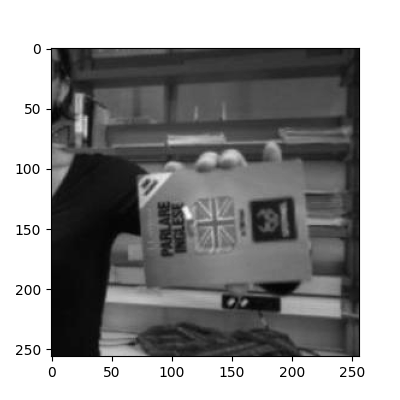

In [20]:
fig = plt.figure(figsize=(4,4))
plt.imshow(prvs, cmap='gray')


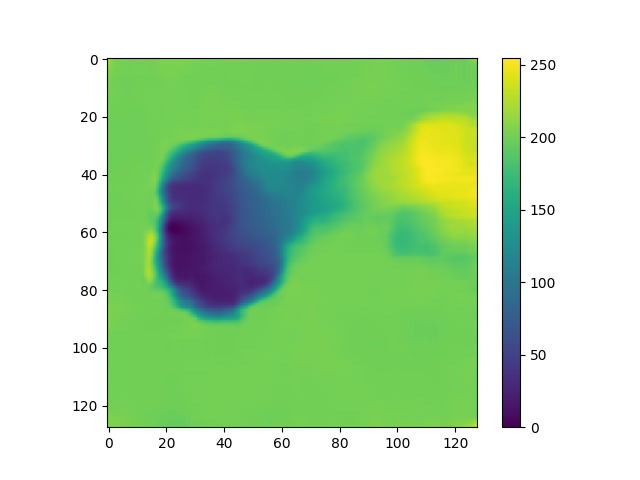

In [57]:
import cv2 as cv
import matplotlib.animation as animation

fn = 50
data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=8)
img_iter = iter(data_loader)

m=50
for i in range(320*m):
    _, _ = next(img_iter)

# cap = cv.VideoCapture(cv.samples.findFile("vtest.avi"))
# ret, frame1 = cap.read()
imgs, labels = next(img_iter)
imgs = np.array(imgs*255, dtype = np.uint8)
frame1 = np.transpose(imgs[0], (1, 2, 0))
prvs = cv.cvtColor(frame1, cv.COLOR_RGB2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
f_ind=0

fig = plt.figure()


ims = []
while f_ind < fn:
    f_ind += 1

    imgs, labels = next(img_iter)
    imgs = np.array(imgs*255, dtype = np.uint8)
    frame2 = np.transpose(imgs[0], (1, 2, 0))
    next_f = cv.cvtColor(frame2, cv.COLOR_RGB2GRAY)

    flow = cv.calcOpticalFlowFarneback(prvs, next_f, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = 255-cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    rgb_flow = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)
    flow_mag = hsv[..., 2]
    prvs = next_f
    im = plt.imshow(flow_mag, animated=True, vmin=0, vmax=255)
    # im = plt.imshow(rgb_flow, animated=True)
    ims.append([im])

    
plt.colorbar()
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat=False)
plt.show()

In [31]:
len(ims)

50

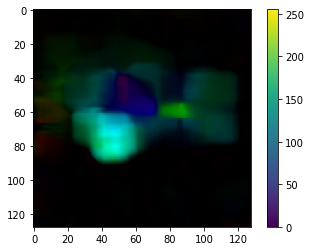

In [215]:
plt.imshow(bgr)
plt.colorbar()

In [7]:
class TimePredictiveSampler():
    def __init__(self, dataset, batch_size, max_ts_future=5):
        self.targets = np.array(dataset.targets)
        self.ds_len = len(self.targets)
        self.n_batches = self.ds_len // batch_size
        self.batch_size = batch_size
        self.max_ts_future=max_ts_future
        
        

    def __iter__(self):    
        batches = []
        for _ in range(self.n_batches):
            batch = []
            instances = np.random.choice(range(self.ds_len), self.batch_size)
            shifted_insts = np.zeros(shape=instances.shape, dtype=int)
            # for i, inst in enumerate(instances):
            #     rand_shift = np.random.choice(range(min(self.max_ts_future,(300-i%300))), 1)          
            #     shifted_insts[i] = inst + rand_shift
            shifted_insts = instances + np.random.choice(range(self.max_ts_future), instances.shape)
            shifted_insts = np.clip(shifted_insts, a_min=0, a_max=self.ds_len - 1)
            overflown = (self.targets[instances] != self.targets[shifted_insts])
            shifted_insts[overflown] = (shifted_insts - self.max_ts_future)[overflown]
            batch.extend(instances)
            batch.extend(shifted_insts)
    
            batches.append(batch)
        
        return iter(batches)
        
    def __len__(self):
        return self.n_batches
        
        

In [8]:
model.backbone.load_state_dict(torch.load("/home/ehajizad/ss_learning/neuromorphic-continual-learning/models/core50_simsiam_resnet9_future_10.pth"))


<All keys matched successfully>

In [9]:
s = TimePredictiveSampler(dataset, 128, 50)
dataloader = DataLoader(dataset,num_workers=8,batch_sampler=s)

In [21]:
core50.targets[119631]

8

In [100]:
sampler_array = np.array(list(s))

In [101]:
np.max(np.max(sampler_array, 1))

119893

In [10]:
print("Starting Training")

criterion = NegativeCosineSimilarity()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

training_loss = []
knn_acc = []

# labels = dataset.df.iloc[:,1].values
# sorted_inds = np.argsort(labels)
# y_sorted = labels[sorted_inds]

validation = False

for epoch in range(100):
    model.train()
    total_loss = 0
    total_bt_loss = 0
    total_norm_loss = 0
    for i, (x, _) in enumerate(dataloader):
        x0,x1 = x.split(int(x.shape[0]/2), dim=0)
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0, p0 = model(x0)
        z1, p1 = model(x1)
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f} ")
    training_loss.append(avg_loss)
    
    if validation:
        embeddings = []
        model.eval()
        with torch.no_grad():
            for batch in feat_ext_dl:
                image, label, _ = batch 
                # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
                image, label = image.to(device), label.to(device)
                emb = model.backbone(image).flatten(start_dim=1)
                embeddings.append(emb)

        embeddings = torch.cat(embeddings, 0)
        embeddings = np.array(torch.Tensor.cpu(embeddings))
        embeddings = embeddings[sorted_inds,...]

        X = embeddings.copy()
        y = y_sorted.copy()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, shuffle=True) # 80% training and 20% test

        sim_X_train = np.matmul(X_train,X_train.T)
        sim_X_test = np.matmul(X_test,X_train.T)

        sim_X_train = np.max(sim_X_train) - sim_X_train
        sim_X_test = np.max(sim_X_test) - sim_X_test

        knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute",  metric="precomputed")
        knn.fit(sim_X_train, y_train)

        y_pred_test=knn.predict(sim_X_test)

        # Model Accuracy: how often is the classifier correct?
        acc = metrics.accuracy_score(y_test, y_pred_test)  
        knn_acc.append(acc)
        print(acc)

Starting Training
epoch: 00, loss: -0.94906 
epoch: 01, loss: -0.99207 
epoch: 02, loss: -0.99443 
epoch: 03, loss: -0.99539 
epoch: 04, loss: -0.99571 
epoch: 05, loss: -0.99610 
epoch: 06, loss: -0.99617 
epoch: 07, loss: -0.99624 
epoch: 08, loss: -0.99625 
epoch: 09, loss: -0.99641 
epoch: 10, loss: -0.99618 
epoch: 11, loss: -0.99593 
epoch: 12, loss: -0.99486 
epoch: 13, loss: -0.99436 
epoch: 14, loss: -0.99469 
epoch: 15, loss: -0.99505 
epoch: 16, loss: -0.99682 
epoch: 17, loss: -0.99694 
epoch: 18, loss: -0.99706 
epoch: 19, loss: -0.99705 
epoch: 20, loss: -0.99708 
epoch: 21, loss: -0.99706 
epoch: 22, loss: -0.99694 
epoch: 23, loss: -0.99666 
epoch: 24, loss: -0.99634 
epoch: 25, loss: -0.99613 
epoch: 26, loss: -0.99618 
epoch: 27, loss: -0.99574 
epoch: 28, loss: -0.99553 
epoch: 29, loss: -0.99528 
epoch: 30, loss: -0.99522 
epoch: 31, loss: -0.99504 
epoch: 32, loss: -0.99521 
epoch: 33, loss: -0.99425 
epoch: 34, loss: -0.99072 
epoch: 35, loss: -0.98749 
epoch: 36,

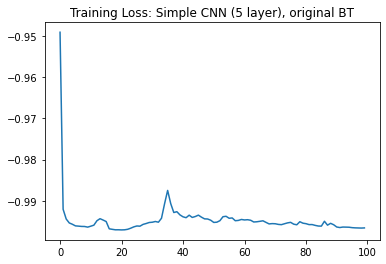

In [11]:
ax1 = plt.subplot()
plt.title("Training Loss: Simple CNN (5 layer), original BT")
training_loss_np = torch.tensor(training_loss, device = 'cpu')
l1, = ax1.plot(training_loss_np)

In [12]:
torch.save(model.backbone.state_dict(), "/home/ehajizad/ss_learning/neuromorphic-continual-learning/models/core50_simsiam_resnet9_future_10_50.pth")

In [8]:
model.backbone

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, 

In [18]:
from torchvision import models
from torchinfo import summary
model = model.backbone[0:-1]
model.eval()
summary(model, (1,3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 512, 8, 8]            --
├─Conv2d: 1-1                            [1, 64, 64, 64]           1,728
├─BatchNorm2d: 1-2                       [1, 64, 64, 64]           128
├─Sequential: 1-3                        [1, 64, 64, 64]           --
│    └─BasicBlock: 2-1                   [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           128
│    │    └─Conv2d: 3-3                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 64, 64]           128
│    │    └─Sequential: 3-5              [1, 64, 64, 64]           --
├─Sequential: 1-4                        [1, 128, 32, 32]          --
│    └─BasicBlock: 2-2                   [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-6                  [1, 128, 32, 32]          73,7